In [2]:
import pandas as pd
import numpy as np
import os
import shutil
from collections import OrderedDict
from datetime import datetime, timedelta
import time
import math
import random

import matplotlib.pyplot as plt

from joblib import dump, load
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix

from scipy.stats import rankdata
from tabulate import tabulate

# Load Predictions Data

In [3]:
pred_file = './predictions/predictions.csv'
pred_df = pd.read_csv(pred_file)
pred_df.head()

,date,track_code,race_num,horse_name,entry,win,win_conf,h2h,odds
0,20180617,NPX,1,FLYING WINE,1,0.0,0.503984,3/5,12.0
1,20180617,NPX,1,LOCKED AND LOADED,2,1.0,0.659808,4/5,3.5
2,20180617,NPX,1,RED RHINO,3,0.0,0.517261,5/5,10.0
3,20180617,NPX,1,MYTHICAL WARRIOR,4,0.0,0.544216,2/5,8.0
4,20180617,NPX,1,MAKEAMERICAGRTAGIN,5,1.0,0.691036,0/5,1.4


# Load All Results Files

In [4]:
# Get all files
path = './results_files/'
results_files = [path + file for file in os.listdir(path) if file.endswith('.2')]

# File field mappings
results_map = OrderedDict({
    1: 'date',
    2: 'race_num',
    4: 'horse_name',
    30: 'rt_odds',
    59: 'finish_pos', 
})

# Parse files into dataframe
results_df = pd.DataFrame()
for ii, file in enumerate(results_files):
    # Open file to dataframe -- Take only columns that are necessary
    cols = [k for k in results_map.keys()]
    tmp_df = pd.read_csv(file, header=None)[cols]
    # Rename cols
    tmp_df.columns = [results_map[col] for col in tmp_df.columns]
    # Add track code
    track_code = file[-13:-10]
    tmp_df['track_code'] = track_code
    # Drop all horses who scratched/dnf
    tmp_df = tmp_df.loc[(tmp_df['finish_pos'] > 0) & (tmp_df['finish_pos'] != 92)]
    # Add these results to dataframe
    results_df = results_df.append(tmp_df)
    # Progress
    print('Processed Files: {}/{}'.format(ii+1, len(results_files)), end='\r', flush=True)
    
# Capitalize results horse names
results_df['horse_name'] = results_df['horse_name'].apply(lambda x: str(x).upper())
results_df.head()

,date,race_num,finish_pos,horse_name,rt_odds,track_code
0,20180729,1,1,LOU'S CHARDONNAY,3.15,SAR
1,20180729,1,2,PROMISES BROKEN,3.00,SAR
2,20180729,1,3,SUMMER PUNCH,2.15,SAR
3,20180729,1,4,TOUGH OLD BIRD,18.90,SAR
4,20180729,1,5,DREAM FEVER,3.30,SAR


# Merge Results with Predictions

In [5]:
master_df = pred_df.merge(results_df, 
                             left_on=['date', 'race_num', 'horse_name', 'track_code'],
                             right_on=['date', 'race_num', 'horse_name', 'track_code'])

# Rename odds to ML_odds
master_df = master_df.rename({'odds':'ml_odds'}, axis=1)

master_df.head()

,date,track_code,race_num,horse_name,entry,win,win_conf,h2h,ml_odds,finish_pos,rt_odds
0,20180617,NPX,1,FLYING WINE,1,0.0,0.503984,3/5,12.0,5,28.20
1,20180617,NPX,1,LOCKED AND LOADED,2,1.0,0.659808,4/5,3.5,4,2.35
2,20180617,NPX,1,RED RHINO,3,0.0,0.517261,5/5,10.0,1,3.00
3,20180617,NPX,1,MYTHICAL WARRIOR,4,0.0,0.544216,2/5,8.0,3,10.65
4,20180617,NPX,1,RUN AWAY LANE,6,1.0,0.655606,1/5,2.0,2,0.80


# Establish Rankings
Iterate through each race, and rank the horses based on various metrics. These rankings will be used to determine how we would have bet in these races if we had used these various metrics. The performance of the metrics will be used to determine an optimal betting strategy.

In [6]:
# Run through day/track combination
track_date_combos = master_df.groupby(['date','track_code']).size().reset_index()
ranked_df = pd.DataFrame()

# Iterate through each track/day
for ii, row in track_date_combos.iterrows():
    print('Processing Track/Date: {}/{}'.format(ii+1, len(track_date_combos)), end='\r', flush=True)
    # Create a separate table for each race
    track_code = row['track_code']
    date = row['date']
    track_df = master_df.loc[(master_df.date == date) & (master_df.track_code == track_code)]
    cols_to_keep = ['date','race_num', 'track_code', 'horse_name', 'entry',\
                    'win', 'win_conf','h2h', 'ml_odds', 'rt_odds']
    for num in range(1, track_df.race_num.max()+1):
        # Get data for this race
        race_df = track_df.loc[track_df['race_num'] == num][cols_to_keep]
        
        # Morning Line Ranking
        race_df['ml_rank'] = rankdata(race_df['ml_odds'], method='min')
        
        # Race Time Ranking
        race_df['rt_rank'] = rankdata(race_df['rt_odds'], method='min')
        
        # H2H Ranking -- convert string column to numeric
        race_df['h2h'] = race_df['h2h'].apply(lambda x: int(x[0]))
        race_df['h2h_rank'] = np.abs(rankdata(race_df['h2h'], method='min') - len(race_df['h2h'])) + 1
        
        # WIN Ranking -- need to sort by win then confidence. Horses projected to win will
        # be first in their confidence order, followed by the losers in reverse-confidence 
        # order. We reverse for losers, since those we are less confident will lose, are
        # implied to be more likely to win.
        winner_idx = race_df.loc[race_df['win'] == 1].index
        loser_idx = race_df.loc[race_df['win'] == 0].index
        sort_win_idx = race_df.loc[winner_idx].sort_values(['win_conf'], ascending=False).index
        sort_lose_idx = race_df.loc[loser_idx].sort_values(['win_conf'], ascending=True).index
        rank_idx = list(sort_win_idx) + list(sort_lose_idx)
        win_rank = pd.Series(range(len(rank_idx)), index=rank_idx) + 1        
        race_df['win_rank'] = win_rank
        
        #WIN/H2H Ranking -- will sort first by win, and then by h2h value
        win_h2h_df = race_df.sort_values(['win', 'h2h'], ascending=False)
        win_h2h_rank = pd.Series(range(len(win_h2h_df)), index=win_h2h_df.index) + 1
        race_df['win_h2h_rank'] = win_h2h_rank
        
        # Add ranked race df to ranked_df
        ranked_df = ranked_df.append(race_df)
        
# Drop all non-rank columns
drop_cols = ['win', 'win_conf', 'h2h', 'ml_odds', 'rt_odds', 'entry']
ranked_df = ranked_df.drop(drop_cols, axis=1)
ranked_df.head()

,date,race_num,track_code,horse_name,ml_rank,rt_rank,h2h_rank,win_rank,win_h2h_rank
2735,20180429,1,FON,I'M LUCKY,5,5,1,4,1
2736,20180429,1,FON,NEW TESTAMENT,4,4,2,2,2
2737,20180429,1,FON,HOLDING FAST,1,1,3,3,3
2738,20180429,1,FON,HEIR HORSE ONE,3,2,5,1,5
2739,20180429,1,FON,TIZAWONDERFULGIFT,2,3,4,5,4


# Get Toal Number of Races

In [7]:
total_races = 0

for ii, row in track_date_combos.iterrows():
    track_code = row['track_code']
    date = row['date']
    track_df = master_df.loc[(master_df.date == date) & (master_df.track_code == track_code)]
    for num in range(1, track_df.race_num.max()+1):
        total_races += 1
        
total_races

3586

# Create Betting DataFrame

In [8]:
betting_df = master_df.merge(ranked_df,
                            left_on=['date', 'race_num', 'track_code', 'horse_name'],
                            right_on=['date', 'race_num', 'track_code', 'horse_name'])

betting_df.head()

,date,track_code,race_num,horse_name,entry,win,win_conf,h2h,ml_odds,finish_pos,rt_odds,ml_rank,rt_rank,h2h_rank,win_rank,win_h2h_rank
0,20180617,NPX,1,FLYING WINE,1,0.0,0.503984,3/5,12.0,5,28.20,5,5,3,3,4
1,20180617,NPX,1,LOCKED AND LOADED,2,1.0,0.659808,4/5,3.5,4,2.35,2,2,2,1,1
2,20180617,NPX,1,RED RHINO,3,0.0,0.517261,5/5,10.0,1,3.00,4,3,1,4,3
3,20180617,NPX,1,MYTHICAL WARRIOR,4,0.0,0.544216,2/5,8.0,3,10.65,3,4,4,5,5
4,20180617,NPX,1,RUN AWAY LANE,6,1.0,0.655606,1/5,2.0,2,0.80,1,1,5,2,2


# Betting Params

In [68]:
ex_bet_amt = 2 # Amt per bet
considered_horses = 2 # Horses to place bets on per race
conf_thresh = 0.6 # Confidence we'd like our win model to listen to prediction

In [69]:
def calc_exacta_payouts(rank_metric, betting_df):
    '''
        Calculate the exacta payouts as if we'd boxed the first two predicted horses
        in every race.
        
        Args:
            rank_metric (str): the ranking field used to determine the top two horses
            betting_df (pd.DataFrame): dataframe containing betting information
         
        Returns:
            (pd.DataFrame): contains information on exacta payouts            
    
    '''
    # Get those horses who were ranked in top 2 by rank_metric
    bet_df = betting_df.loc[betting_df[rank_metric] <= considered_horses]
    bet_df = bet_df[['date', 'track_code', 'race_num', 'horse_name', 'finish_pos', 'rt_rank', 'rt_odds']]

    # Set up dataframe to hold exacta entries
    ex_df = pd.DataFrame()

    # Iterate through each track/race and get finish positions/expected odds
    track_race_combos = bet_df.groupby(['date','track_code', 'race_num']).size().reset_index()
    for ii, item in track_race_combos.iterrows():
        print('Race {}/{}'.format(ii+1, len(track_race_combos)), end='\r', flush=True)
        date = item.date
        track_code = item.track_code
        race_num = item.race_num
        # Get horses in this race
        race_df = bet_df.loc[(bet_df.date == date) &
                                (bet_df.track_code == track_code) &
                                (bet_df.race_num == race_num)]

        # Ensure that only two horses were predicted for this race
        if len(race_df) == 2:
            # Create entry for exacta df -- include estimated odds, hit/no hit, and payout
            hit = np.max(race_df.finish_pos) == 2 # Was this exacta successful?
            est_odds = round(np.cumprod(race_df.rt_odds).iloc[-1], 2) # Product of horses' odds
            bet_cost = 2 * ex_bet_amt
            # If odds not enough to cover bets, don't bet
            if est_odds < bet_cost:
                payout = 0
            else:
                # If bet successful, calc payout, otherwise we lost money from box
                if hit:
                    payout = round((est_odds * ex_bet_amt) - ex_bet_amt, 2) # Payout - cost of other exacta in box
                else:
                    payout = -bet_cost

            # Create entry and append to exacta dataframe
            entry = pd.DataFrame.from_dict({
                'date': [date],
                'track_code': [track_code],
                'race_num': [race_num],
                'hit': [int(hit)],
                'finish_pos': [race_df.finish_pos.values], 
                'est_odds': [est_odds],
                'payout': [payout]
            })

            ex_df = ex_df.append(entry)
        else:
            continue
            
    # Return exacta results
    return ex_df

# Bet According To ML Odds
If we did win bets on the top 3 horses every race, as projected by ML Odds, what would returns be?

In [70]:
ml_ex_df = calc_exacta_payouts('ml_rank', betting_df)    
ml_ex_df.head(10)

,date,est_odds,finish_pos,hit,payout,race_num,track_code
0,20180429,2.80,"[2, 1]",1,0.00,1,FON
0,20180429,4.80,"[1, 3]",0,-4.00,2,FON
0,20180429,5.80,"[1, 3]",0,-4.00,3,FON
0,20180429,4.05,"[4, 1]",0,-4.00,4,FON
0,20180429,17.68,"[6, 1]",0,-4.00,5,FON
0,20180429,5.16,"[1, 2]",1,8.32,6,FON
0,20180429,2.24,"[2, 3]",0,0.00,7,FON
0,20180429,8.58,"[2, 3]",0,-4.00,8,FON
0,20180429,4.00,"[2, 1]",1,6.00,1,GGX
0,20180429,6.50,"[2, 3]",0,-4.00,2,GGX


# Bet According to RT Odds
**This is our benchmark**

In [71]:
rt_ex_df = calc_exacta_payouts('rt_rank', betting_df)    
rt_ex_df.head(10)

,date,est_odds,finish_pos,hit,payout,race_num,track_code
0,20180429,2.00,"[2, 3]",0,0.0,1,FON
0,20180429,4.80,"[1, 3]",0,-4.0,2,FON
0,20180429,3.40,"[1, 4]",0,0.0,3,FON
0,20180429,4.05,"[4, 1]",0,-4.0,4,FON
0,20180429,5.44,"[6, 2]",0,-4.0,5,FON
0,20180429,3.00,"[1, 3]",0,0.0,6,FON
0,20180429,2.24,"[2, 3]",0,0.0,7,FON
0,20180429,7.70,"[1, 3]",0,-4.0,8,FON
0,20180429,3.20,"[1, 4]",0,0.0,1,GGX
0,20180429,5.20,"[1, 2]",1,8.4,2,GGX


# Bet According to WIN Model

In [72]:
win_ex_df = calc_exacta_payouts('win_rank', betting_df)
win_ex_df.head(10)

,date,est_odds,finish_pos,hit,payout,race_num,track_code
0,20180429,22.75,"[5, 3]",0,-4.00,1,FON
0,20180429,4.80,"[1, 3]",0,-4.00,2,FON
0,20180429,3.40,"[1, 4]",0,0.00,3,FON
0,20180429,4.05,"[4, 1]",0,-4.00,4,FON
0,20180429,8.32,"[2, 1]",1,14.64,5,FON
0,20180429,10.75,"[2, 3]",0,-4.00,6,FON
0,20180429,18.13,"[3, 8]",0,-4.00,7,FON
0,20180429,9.02,"[7, 3]",0,-4.00,8,FON
0,20180429,14.50,"[2, 3]",0,-4.00,1,GGX
0,20180429,66.80,"[1, 6]",0,-4.00,2,GGX


# Bet According to H2H Model

In [73]:
h2h_ex_df = calc_exacta_payouts('h2h_rank', betting_df)
h2h_ex_df.head(10)

,date,est_odds,finish_pos,hit,payout,race_num,track_code
0,20180429,94.64,"[4, 5]",0,-4.0,1,FON
0,20180429,26.16,"[1, 6]",0,-4.0,2,FON
0,20180429,82.36,"[6, 3]",0,-4.0,3,FON
0,20180429,113.16,"[3, 5]",0,-4.0,4,FON
0,20180429,6.40,"[5, 2]",0,-4.0,5,FON
0,20180429,27.09,"[2, 4]",0,-4.0,6,FON
0,20180429,48.64,"[4, 2]",0,-4.0,7,FON
0,20180429,93.99,"[6, 2]",0,-4.0,8,FON
0,20180429,27.68,"[1, 5]",0,-4.0,1,GGX
0,20180429,103.54,"[5, 6]",0,-4.0,2,GGX


# Bet According the WIN/H2H Model

In [74]:
wh2h_ex_df = calc_exacta_payouts('win_h2h_rank', betting_df)
wh2h_ex_df.head(10)

,date,est_odds,finish_pos,hit,payout,race_num,track_code
0,20180429,94.64,"[4, 5]",0,-4.00,1,FON
0,20180429,6.72,"[1, 4]",0,-4.00,2,FON
0,20180429,5.90,"[1, 5]",0,-4.00,3,FON
0,20180429,20.70,"[3, 1]",0,-4.00,4,FON
0,20180429,6.40,"[5, 2]",0,-4.00,5,FON
0,20180429,5.16,"[1, 2]",1,8.32,6,FON
0,20180429,10.64,"[4, 3]",0,-4.00,7,FON
0,20180429,9.02,"[7, 3]",0,-4.00,8,FON
0,20180429,27.68,"[1, 5]",0,-4.00,1,GGX
0,20180429,103.54,"[5, 6]",0,-4.00,2,GGX


# Get Cumulative Returns for Each Strategy

In [75]:
#Df for cumulative returns
idx = pd.date_range(start='4/29/2018', end='11/03/2018')
rets_df = pd.DataFrame(index=idx, columns=['ml_ret', 'rt_ret', 'win_ret', 'h2h_ret', 'win_h2h_ret'])

# Convert date strings to dates
ml_ex_df['date'] = ml_ex_df['date'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
rt_ex_df['date'] = rt_ex_df['date'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
win_ex_df['date'] = win_ex_df['date'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
h2h_ex_df['date'] = h2h_ex_df['date'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
wh2h_ex_df['date'] = wh2h_ex_df['date'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))

# Group each DF by Date
ml_ex_df = ml_ex_df.groupby(['date']).sum()
rt_ex_df = rt_ex_df.groupby(['date']).sum()
win_ex_df = win_ex_df.groupby(['date']).sum()
h2h_ex_df = h2h_ex_df.groupby(['date']).sum()
wh2h_ex_df = wh2h_ex_df.groupby(['date']).sum()

# Get cumulative returns
ml_ex_df['cum_ret'] = np.cumsum(ml_ex_df.payout)
rt_ex_df['cum_ret'] = np.cumsum(rt_ex_df.payout)
win_ex_df['cum_ret'] = np.cumsum(win_ex_df.payout)
h2h_ex_df['cum_ret'] = np.cumsum(h2h_ex_df.payout)
wh2h_ex_df['cum_ret'] = np.cumsum(wh2h_ex_df.payout)

# Join cumulative returns to cumulative returns df
rets_df.loc[ml_ex_df.index, 'ml_ret'] = ml_ex_df['cum_ret']
rets_df.loc[rt_ex_df.index, 'rt_ret'] = rt_ex_df['cum_ret']
rets_df.loc[win_ex_df.index, 'win_ret'] = win_ex_df['cum_ret']
rets_df.loc[h2h_ex_df.index, 'h2h_ret'] = h2h_ex_df['cum_ret']
rets_df.loc[wh2h_ex_df.index, 'win_h2h_ret'] = wh2h_ex_df['cum_ret']

# Forward Fill Nan Values
rets_df.fillna(method='ffill', inplace=True)

# Print out cumulative returns for all strategies
ml_returns = round(rets_df.iloc[-1].ml_ret, 2)
rt_returns = round(rets_df.iloc[-1].rt_ret, 2)
win_returns = round(rets_df.iloc[-1].win_ret, 2)
h2h_returns = round(rets_df.iloc[-1].h2h_ret, 2)
wh2h_returns = round(rets_df.iloc[-1].win_h2h_ret, 2)


print('ML Returns: {}'.format(ml_returns))
print('RT Returns: {}'.format(rt_returns))
print('WIN Returns: {}'.format(win_returns))
print('H2H Returns: {}'.format(h2h_returns))
print('WIN/H2H Returns: {}'.format(wh2h_returns))

ML Returns: -4323.04
RT Returns: -3362.6
WIN Returns: -3442.96
H2H Returns: -7654.54
WIN/H2H Returns: -6306.54


# Plot Cumulative Returns

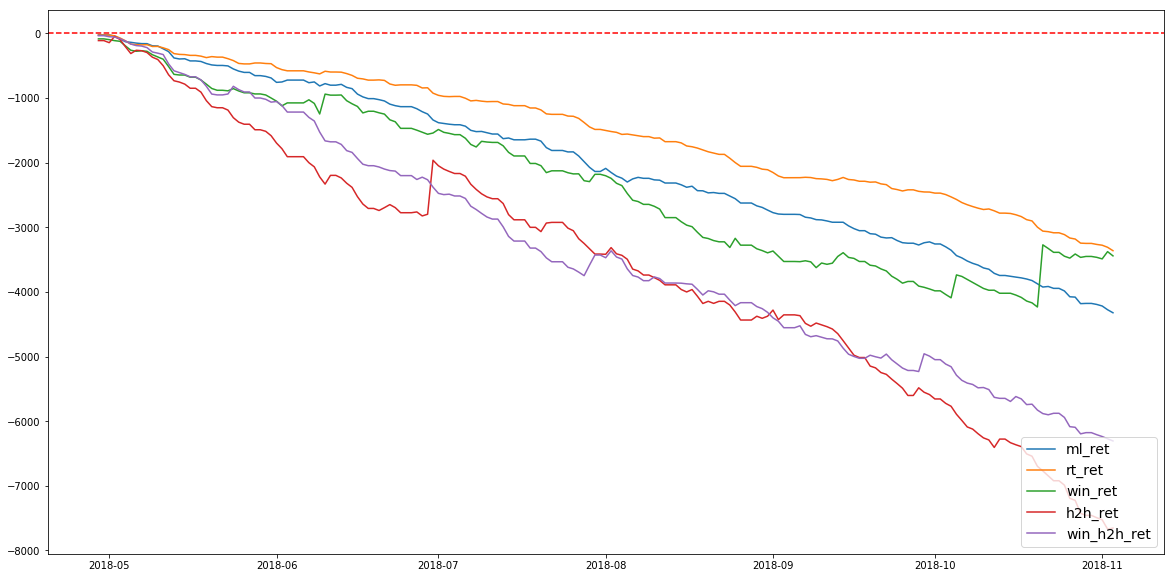

In [76]:
plt.figure(figsize=(20,10))

plt.plot(rets_df.index, rets_df.ml_ret)
plt.plot(rets_df.index, rets_df.rt_ret)
plt.plot(rets_df.index, rets_df.win_ret)
plt.plot(rets_df.index, rets_df.h2h_ret)
plt.plot(rets_df.index, rets_df.win_h2h_ret)

plt.legend(loc=4, prop={'size': 14})
plt.axhline(y=0, color='r', linestyle='--')
plt.show()